In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, log_scale
from ALLCools.plot import *

In [2]:
null_ratio = 0.5
cov_ratio = 0.9
mc_type = 'CHN'

In [3]:
# change this to the paths to your MCDS files, 
# ALLCools.MCDS can handle multiple MCDS files automatically
mcds_path = 'simulated.mcds'

# Dimension name used to do clustering
# This corresponding to AnnData .obs and .var
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature


# feature cov cutoffs
min_cov = 500 * cov_ratio
max_cov = 3000 * cov_ratio

# load to memory or not
load = True
n_top_feature = 20000 * null_ratio

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

In [4]:
mcds = MCDS.open(
    mcds_path, 
    obs_dim='cell')
total_feature = mcds.get_index(var_dim).size
mcds = mcds.expand_dims(dim={'mc_type': [mc_type]}) # coord name doesn't matter

In [5]:
true_labels = pd.read_csv('true_labels.csv', index_col=0)

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


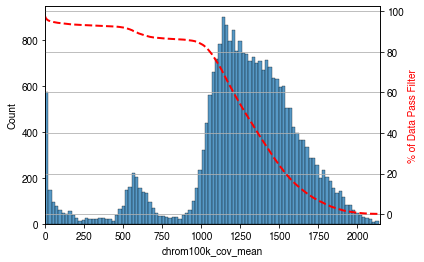

In [6]:
mcds.add_feature_cov_mean(var_dim=var_dim)

In [7]:
# filter by coverage - based on the distribution above
mcds = mcds.filter_feature_by_cov_mean(
    var_dim=var_dim,
    min_cov=5,  # minimum coverage
    max_cov=9999999  # Maximum coverage
)

Before cov mean filter: 27269 chrom100k
 After cov mean filter: 26350 chrom100k 96.6%


In [8]:
mcds.add_mc_frac(
    var_dim=var_dim, 
    normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

In [9]:
mch_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
                                 mc_type=mc_type,
                                 n_top_feature=int(n_top_feature),
                                 plot=True)

Fitting SVR with gamma 0.0380, predicting feature dispersion using mc_frac_mean and cov_mean.
Total Feature Number:     26350
Highly Variable Feature:  10000 (38.0%)


In [10]:
adata = mcds.get_adata(mc_type=mc_type,
                           var_dim=var_dim,
                           select_hvf=True)
adata

AnnData object with n_obs × n_vars = 1143 × 10000
    var: 'bin_end', 'bin_start', 'chrom', 'cov_mean', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select'

In [11]:
for col, data in true_labels.items():
    adata.obs[col] = data

In [12]:
cell_sum = mcds['chrom100k_da'].sum(dim='chrom100k')
cell_frac = cell_sum.sel(count_type='mc') / cell_sum.sel(count_type='cov')
adata.obs['cell_frac'] = cell_frac.squeeze().to_pandas()
adata.obs['cell_cov'] = cell_sum.sel(count_type='cov').squeeze().to_pandas()

In [13]:
log_scale(adata)

StandardScaler(with_mean=False)

18 components passed P cutoff of 0.2.
Changing adata.obsm['X_pca'] from shape (1143, 50) to (1143, 18)
Red axis labels are used PCs


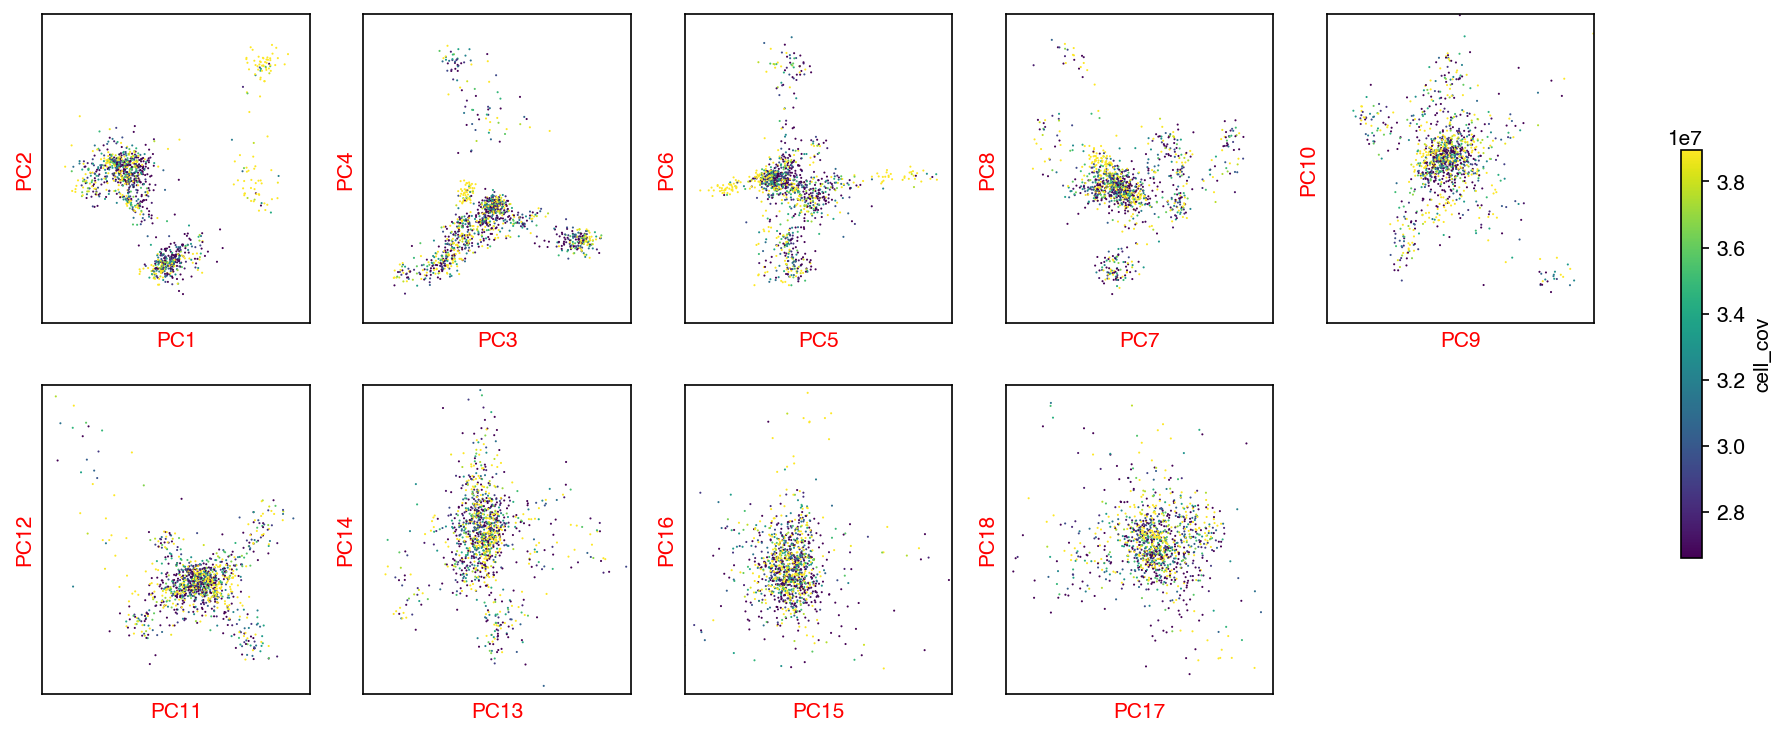

In [14]:
sc.tl.pca(adata)
ch_n_components = significant_pc_test(adata, p_cutoff=0.2)
fig, axes = plot_decomp_scatters(adata,
                                 n_components=ch_n_components,
                                 hue='cell_cov',
                                 nrows=3,
                                 ncols=5)

In [15]:
if knn == -1:
    knn = max(15, int(np.log2(adata.shape[0])*2))
sc.pp.neighbors(adata, n_neighbors=knn)

In [16]:
sc.tl.leiden(adata, resolution=resolution)

In [17]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

[Text(0.5, 1.0, 'True Cluster')]

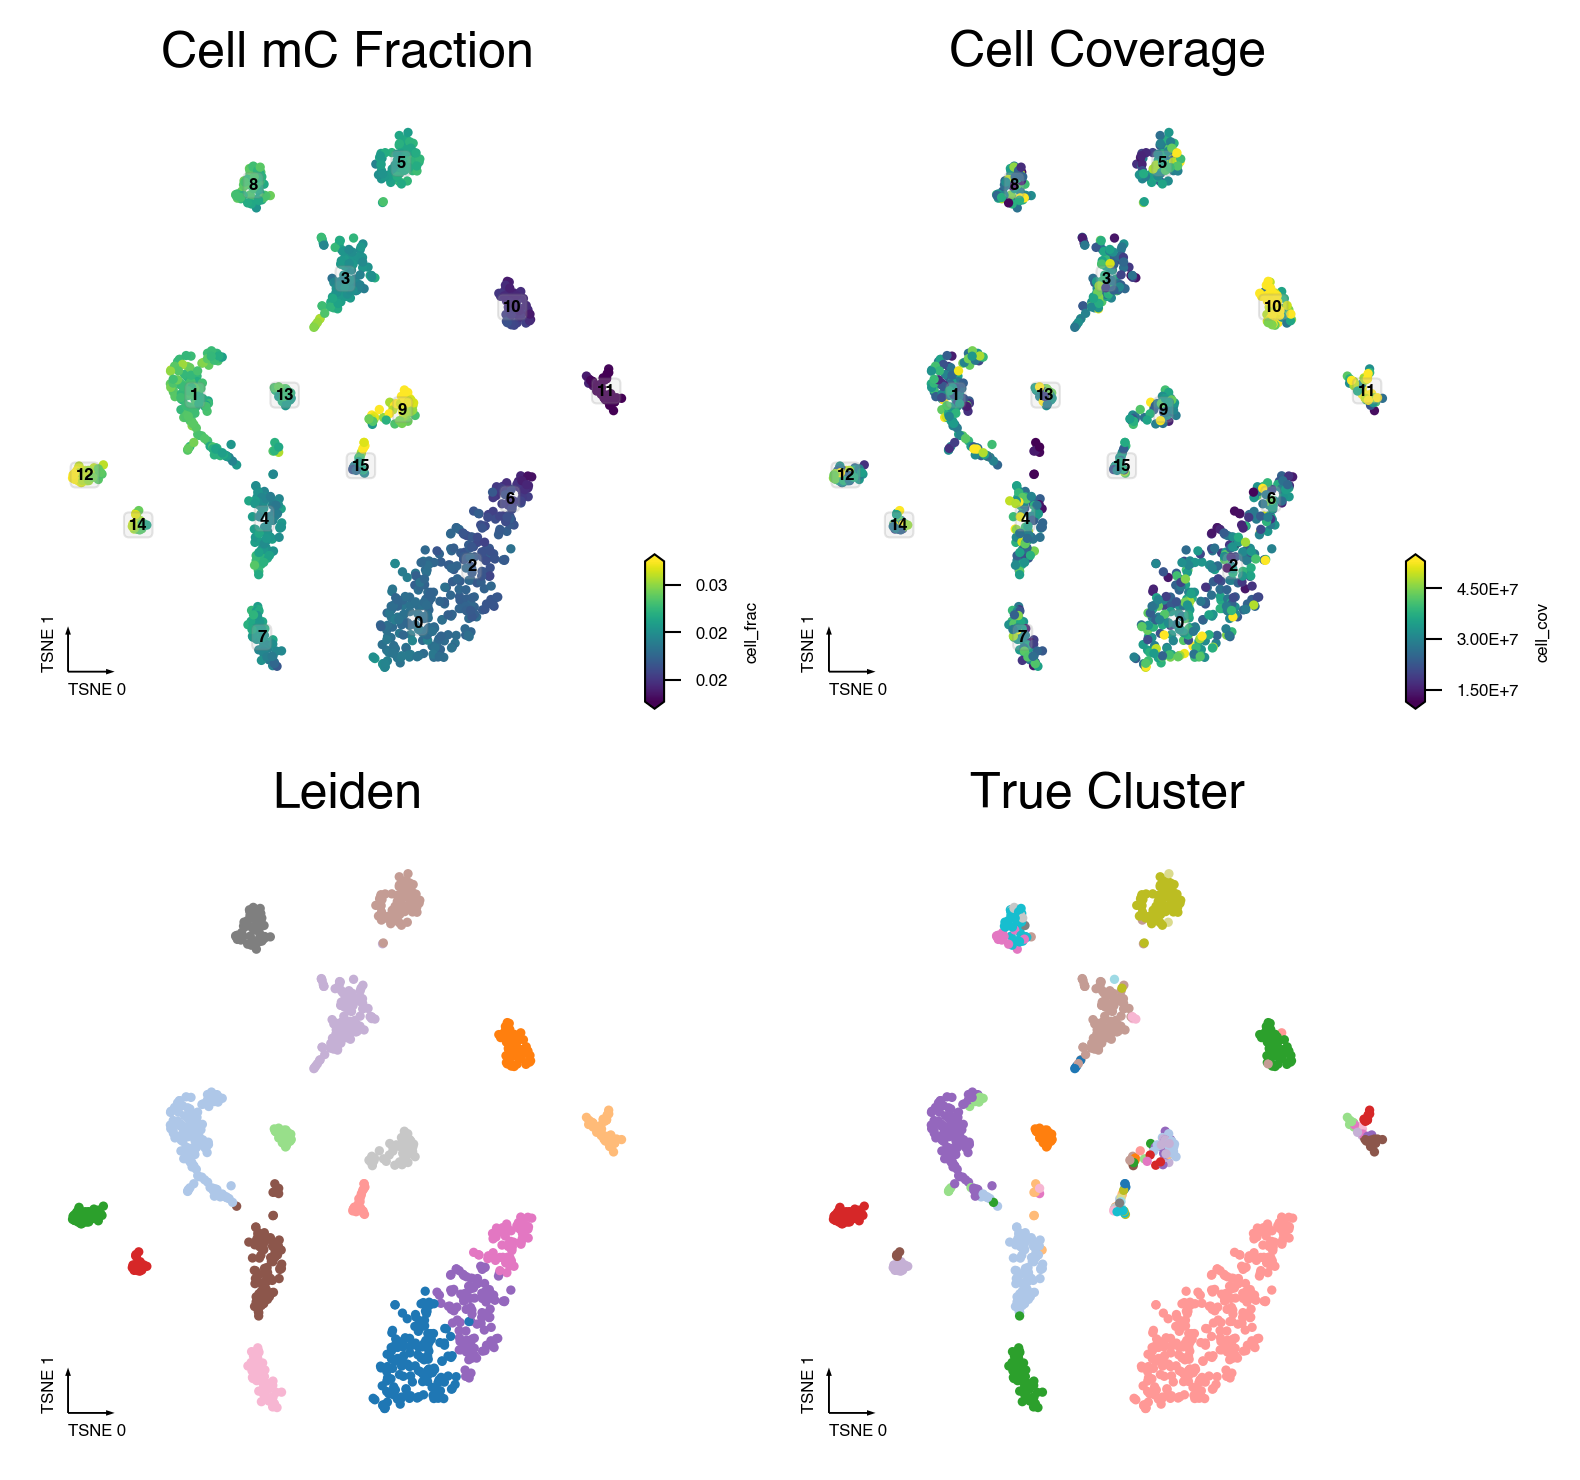

In [18]:
fig, axes = plt.subplots(figsize=(6, 6), dpi=300, ncols=2, nrows=2)

ax = axes[0, 0]
_ = continuous_scatter(data=adata,
                        ax=ax,
                        coord_base='tsne',
                        hue='cell_frac',
                        text_anno='leiden')
ax.set(title='Cell mC Fraction')
ax = axes[0, 1]
_ = continuous_scatter(data=adata,
                        ax=ax,
                        coord_base='tsne',
                        hue='cell_cov',
                        text_anno='leiden')
ax.set(title='Cell Coverage')

ax = axes[1, 0]
_ = categorical_scatter(data=adata,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        # text_anno='leiden',
                        show_legend=False)
ax.set(title='Leiden')

ax = axes[1, 1]
_ = categorical_scatter(data=adata,
                        ax=ax,
                        coord_base='tsne',
                        hue='L2',
                        palette='tab20',
                        # text_anno='L2',
                        show_legend=False)
ax.set(title='True Cluster')